In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 

In [2]:
import sys

def get_n_dir_up(path, n):
    for _ in range(n):
        path = os.path.dirname(path)
    return path

CUR_PATH= os.path.abspath("__file__")
SUBJ_BEHAV_DIR = os.path.join(get_n_dir_up(CUR_PATH, 3), "data", "behavior", "subjects")

In [3]:
import json

DEFAULT_DATA_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'data')
with open(os.path.join(DEFAULT_DATA_FOLDER, 'QA.json')) as f:
    qa_records = json.load(f)

invalid_subjs = qa_records['invalid']

In [4]:
PLOTS_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'results', 'images', 'behavior')

## Compare Draw v.s. Click

### convert response to distribution

In [5]:
def deg_signed_diff(d1, epoch=180):
    d2 = - np.sign(d1) * (epoch - np.abs(d1))
    mask = np.abs(d1) < np.abs(d2)
    d = mask * d1 + (~mask) * d2
    # finally, convert 90 to -90
    half_epoch = epoch // 2
    mask_90 = d == half_epoch
    d = mask_90 * (-half_epoch) + (~mask_90) * d
    return d

def df_to_errs(df, lmb):
    if lmb is not None:
        mask = lmb(df)
        df = df[mask]
    # tease out stim 1 and stim 2
    stims = np.concatenate([
        df['stim_1'].to_numpy(copy=True),
        df['stim_2'].to_numpy(copy=True)
    ])
    resps = np.concatenate([
        df['resp_1'].to_numpy(copy=True),
        df['resp_2'].to_numpy(copy=True)
    ])
    subjects = np.concatenate([
        df['participant'].to_numpy(copy=True),
        df['participant'].to_numpy(copy=True)
    ])
    # remove nan
    valid_mask = ~(np.isnan(resps))
    errs = deg_signed_diff(resps[valid_mask]-stims[valid_mask])
    subjects = subjects[valid_mask]
    stims = stims[valid_mask]
    # collect results
    results = pd.DataFrame({
        'subject': subjects,
        'stim': stims,
        'err': errs,
    })
    return results

In [6]:
example_df = pd.read_csv(os.path.join(SUBJ_BEHAV_DIR, "908.csv"))
example_err_df = df_to_errs(example_df, None)

In [7]:
def errdf_to_distrib(err_df, T=180):
    # convert err to distrib
    distrib = np.zeros(T)
    err_ids = err_df['err'].to_numpy().astype(int) % T
    np.add.at(distrib, err_ids, 1)
    distrib = distrib / np.sum(distrib)
    return distrib

def compute_accuracy(distrib, T=180):
    # 0 --> err = 0
    # 0.5 --> max err
    degs = np.linspace(0, 360, T, endpoint=False)
    errs = deg_signed_diff(degs, epoch=360)
    baseline_vec = np.cos(np.deg2rad(errs))

    # baseline_vec = baseline_vec / np.linalg.norm(baseline_vec)
    # distrib_vec = distrib
    distrib_vec = distrib / np.linalg.norm(distrib, axis=-1, keepdims=True)
    acc = np.sum(distrib_vec * baseline_vec, axis=-1)
    return acc

def compute_bias(distrib, T=180, err_thresh=40):
    # 0 --> no bias
    # 0.25 --> most positive bias
    # 0.5 --> neutral?
    # 0.75 --> most negative bias
    degs = np.linspace(0, 360, T, endpoint=False)
    errs = deg_signed_diff(degs, epoch=360)
    baseline_vec = np.sin(np.deg2rad(errs))

    # baseline_vec = baseline_vec / np.linalg.norm(baseline_vec)
    # distrib_vec = distrib
    distrib_vec = distrib / np.linalg.norm(distrib, axis=-1, keepdims=True)

    # error filtering
    total_weights = np.linalg.norm(baseline_vec)
    if err_thresh is None:
        err_thresh = 180
    mask = np.abs(errs) <= (err_thresh * 360 / T)
    distrib_vec = distrib_vec[mask]
    baseline_vec = baseline_vec[mask]
    kept_weights = np.linalg.norm(baseline_vec)

    ratio = total_weights / kept_weights
    bias = np.sum(distrib_vec * baseline_vec, axis=-1) * ratio
    return bias

In [8]:
draw_lmb = lambda df: (df['mode'] == 'draw').to_numpy()
click_lmb = lambda df: (df['mode'] == 'click').to_numpy()

In [9]:
def get_stim_restrict_bias(common_lmb, center_sample, window_size):
    # collect errors
    err_dfs = []
    for subjf in os.listdir(SUBJ_BEHAV_DIR):
        subj = subjf.split('.')[0]
        if subj in invalid_subjs:
            continue
        subj_df = pd.read_csv(os.path.join(SUBJ_BEHAV_DIR, subjf))
        err_dfs.append(df_to_errs(subj_df, common_lmb))
    err_dfs = pd.concat(err_dfs, axis=0, ignore_index=True)

    # masked out by stims
    if window_size is not None:
        stim_within_range_mask = (
            np.abs(deg_signed_diff(err_dfs['stim'].values -center_sample)) <= window_size)
        err_dfs = err_dfs[stim_within_range_mask]

    # grouped by subject
    subj_accs = {}
    subj_bias = {}

    for subj, subjdf in err_dfs.groupby('subject'):
        # collect errors
        distrib = errdf_to_distrib(subjdf, T=180)
        # compute accuracy and bias
        acc = compute_accuracy(distrib, T=180)
        bias = compute_bias(distrib, T=180)
        # collect results
        subj_accs[subj] = acc
        subj_bias[subj] = bias

    return subj_accs, subj_bias

def display_acc_bias_as_tuning(common_lmb, condition_name):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    sample_step = 15
    sample_xs = np.arange(int(180/sample_step)) * sample_step
    collected_sample_stats = []
    for sample_x in sample_xs:
        accs, biases = get_stim_restrict_bias(
            common_lmb=common_lmb,
            center_sample=sample_x,
            window_size=sample_step/2, # to match the gaze analysis
        )
        acc_mean = np.mean(list(accs.values()))
        acc_sem = np.std(list(accs.values())) / np.sqrt(len(accs))
        bias_mean = np.mean(list(biases.values()))
        bias_sem = np.std(list(biases.values())) / np.sqrt(len(biases))
        collected_sample_stats.append({
            'accuracy': {
                'mean': acc_mean,
                'sem': acc_sem,
            },
            'bias': {
                'mean': bias_mean,
                'sem': bias_sem,
            }
        })

    sample_xs = np.append(sample_xs, 180)
    collected_sample_stats.append(collected_sample_stats[0])
        
    for i, stat_name in enumerate(['accuracy', 'bias']):
        stats_mean = np.array([
            collected_sample_stats[i][stat_name]['mean'] for i in range(len(sample_xs))])
        stats_sem = np.array([
            collected_sample_stats[i][stat_name]['sem'] for i in range(len(sample_xs))])
        axs[i].errorbar(sample_xs, stats_mean, yerr=stats_sem, fmt='o', capsize=5)

        axs[i].set_xlabel('Stim Degree')
        axs[i].axvline(45, color='gray', linestyle='--', alpha=0.5)
        axs[i].axvline(90, color='gray', linestyle='--')
        axs[i].axvline(135, color='gray', linestyle='--', alpha=0.5)
        axs[i].axhline(0, color='red', linestyle='--')

        axs[i].set_xticks(sample_xs)

    axs[0].set_ylim([0, 3.5])
    # axs[0].set_yticks(np.arange(-0.1, 1.3, 0.2))
    axs[0].set_ylabel('accuracy', fontsize=14)
    axs[1].set_ylim([-2, 2])
    # axs[1].set_yticks(np.arange(-0.2, 0.3, 0.1))
    axs[1].set_ylabel('bias', fontsize=14)

    # save the result
    plt.tight_layout()
    plot_path = os.path.join(
        PLOTS_FOLDER, f'cardinal_oblique_{condition_name}.png')
    plt.savefig(plot_path, bbox_inches='tight')

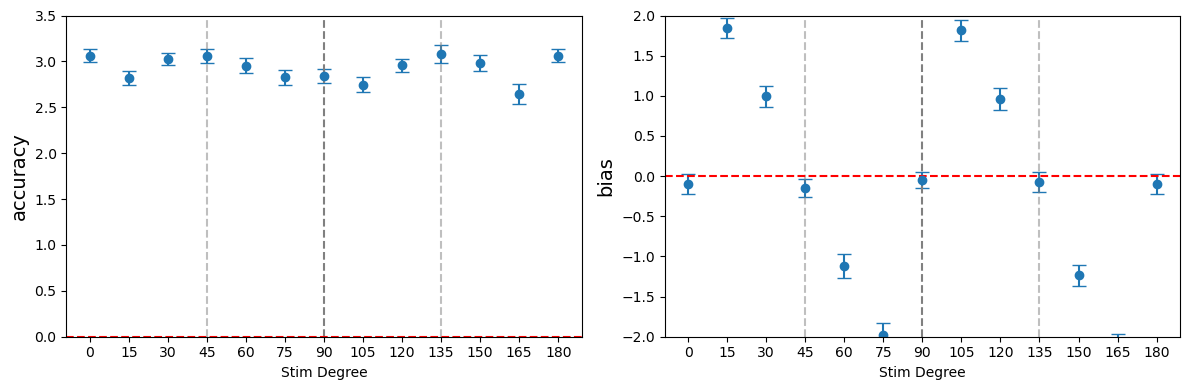

In [12]:
default_lmb = lambda d: np.ones(d.shape[0], dtype=bool)
display_acc_bias_as_tuning(default_lmb, 'all')

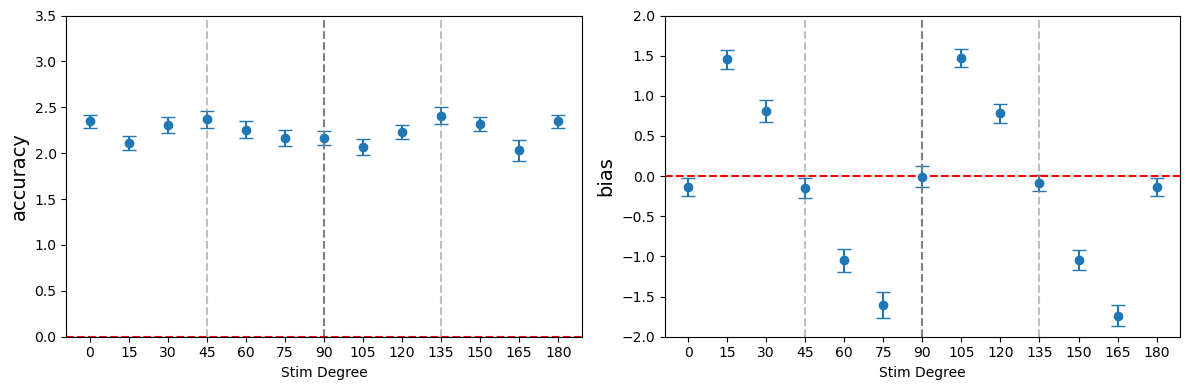

In [10]:
display_acc_bias_as_tuning(draw_lmb, 'draw')

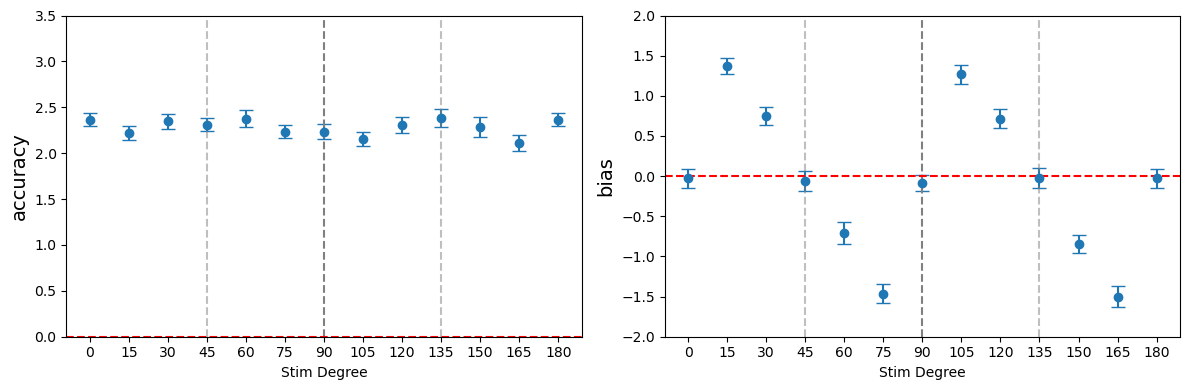

In [11]:
display_acc_bias_as_tuning(click_lmb, 'click')

## Contextual Biases